Installing the energyflow and h5py packages in the Colab environment

In [2]:
!pip install energyflow
!pip install h5py

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Installing POT (Python Optimal Transform) package

In [3]:
!pip install POT

Defaulting to user installation because normal site-packages is not writeable


Import all necessary packages

In [4]:
# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical

# attempt to import sklearn
try:
    from sklearn.metrics import roc_auc_score, roc_curve
except:
    print('please install scikit-learn in order to make ROC curves')
    roc_curve = False

# attempt to import matplotlib
try:
    import matplotlib.pyplot as plt
except:
    print('please install matplotlib in order to make plots')
    plt = False

Using TensorFlow backend.


Load particle distribution from SIM dataset

In [5]:
# load data
specs = ['375 <= corr_jet_pts <= 425', 'abs_jet_eta < 1.9', 'quality >= 2']
amount = 0.2
sim = ef.mod.load(*specs, dataset='sim', amount=amount)
print("Number of jets: ", len(sim))

print("Max: ", np.amax(sim.jet_ms))
print("Min: ", np.amin(sim.jet_ms))

Number of jets:  504909
Max:  143.2047119
Min:  3.663904428


In [6]:
#print(sim.evns)
#print(sim.rns)
sim_numbers = set(sim.evns)
run_numbers = set(sim.rns)
#print(sim_numbers)
#print(run_numbers) #don't need to sort by run number, since they're all the same
print(len(sim_numbers))
print(len(run_numbers))

442886
1


In [7]:
print(sim.evns[2])

5091631


In [8]:
len(sim.particles[sim.jets_i[:,sim.evn]==5091631])

1

Group by events and generate Cartesian coordinate 4 vectors to calculate mass. Also get information on whether particle is a quark or gluon.

In [9]:
from time import process_time

In [10]:
t1_start = process_time() 

event_list = []

event_pts = []
event_etas = []
event_phis = []
event_ms = []

for evn_num in sim_numbers:
    event_list.append(np.asarray(sim.particles[sim.jets_i[:,sim.evn]==evn_num])) #Try grabbing indices maybe? instead of copying data

    event_pts.append(np.asarray(sim.jet_pts[sim.jets_i[:,sim.evn]==evn_num]))
    event_etas.append(np.asarray(sim.jet_etas[sim.jets_i[:,sim.evn]==evn_num]))
    event_phis.append(np.asarray(sim.jet_phis[sim.jets_i[:,sim.evn]==evn_num]))
    event_ms.append(np.asarray(sim.jet_ms[sim.jets_i[:,sim.evn]==evn_num]))
    
t1_stop = process_time()

print("Elapsed time during the whole program in seconds:", t1_stop-t1_start)

Elapsed time during the whole program in seconds: 2418.042138097


In [32]:
event_jet_labels = []
for evn_num in sim_numbers:
    event_jet_labels.append(np.asarray(sim.hard_pids[sim.jets_i[:,sim.evn]==evn_num]))

In [11]:
len(event_list)

442886

In [12]:
print(len(event_pts))
print(len(event_etas))
print(len(event_phis))
print(len(event_ms))

442886
442886
442886
442886


In [13]:
max_jets_in_event = max([len(event_pts[i]) for i in range(len(event_pts))])
print(max_jets_in_event)

4


In [14]:
#New code for compiling 4-vectors

event_stats = []

for i in range(len(event_pts)):
    event_stats.append([])
    
    for j in range(len(event_pts[i])):
        ptyphims = []
        ptyphims.append(event_pts[i][j])
        ptyphims.append(event_etas[i][j])
        ptyphims.append(event_phis[i][j])
        ptyphims.append(event_ms[i][j])
        p4s = ef.p4s_from_ptyphims(np.array(ptyphims))
        
        event_stats[i].append(p4s.tolist())

In [15]:
len(event_stats)

442886

Select events with only 2 jets in them

In [16]:
event_list_2 = []
indexes = []
i = 0
for evn in event_list:
    if len(evn) == 2:
      event_list_2.append(evn)
      indexes.append(i)
    i += 1
event_stats_2 = [event_stats[j] for j in indexes]

In [33]:
event_jet_labels_2 = [event_jet_labels[j] for j in indexes]

In [17]:
print(len(event_list_2))
print(len(event_stats_2))

58108
58108


In [18]:
print(len(event_stats_2))
print(len(event_stats_2[0]))
print(len(event_stats_2[0][0]))

58108
2
4


Find event masses by combining 4 vectors

In [19]:
event_stats_added_2 = []
for i in range(len(event_stats_2)):
    event_1 = event_stats_2[i][0][0] + event_stats_2[i][1][0]
    event_2 = event_stats_2[i][0][1] + event_stats_2[i][1][1]
    event_3 = event_stats_2[i][0][2] + event_stats_2[i][1][2]
    event_4 = event_stats_2[i][0][3] + event_stats_2[i][1][3]
    event = [event_1, event_2, event_3, event_4]
    event_stats_added_2.append(event)

In [20]:
sum_mass_events_2 = []
for event_4_vector in event_stats_added_2:
    event_4_list = list(event_4_vector)
    event_4_array = np.array(event_4_list)
    event_mass = ef.ms_from_p4s(event_4_array)
    sum_mass_events_2.append(event_mass)

In [21]:
max_event_mass = max(sum_mass_events_2)
min_event_mass = min(sum_mass_events_2)

print("Max Event Mass: ", max_event_mass)
print("Min Event Mass: ", min_event_mass)

Max Event Mass:  2624.0850265252584
Min Event Mass:  64.67496843735614


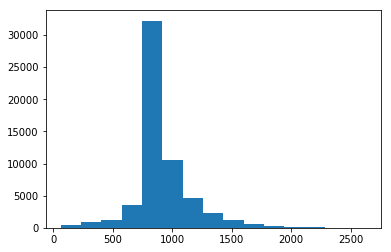

In [22]:
plt.hist(sum_mass_events_2, bins = 15)
plt.show()

In [23]:
event_masses = np.array(sum_mass_events_2)
indices_sorted_evmass = np.argsort(event_masses)
print(event_stats_added_2[indices_sorted_evmass[0]])
print(event_stats_added_2[indices_sorted_evmass[1]])
print(event_stats_added_2[indices_sorted_evmass[2]])
print(event_stats_added_2[indices_sorted_evmass[3]])

[869.713037023758, -563.6786008465779, 505.56088099719614, -422.9569077101105]
[961.1580333695374, 744.1343451967591, -180.81725915428285, -577.1646759604872]
[923.062383525554, 509.7100280250164, 567.567924804797, 514.923338613902]
[1257.0093140192248, -334.0737155299654, -677.2828312122451, -1002.2312729304804]


In [24]:
print(event_stats_2[indices_sorted_evmass[0]])
print(event_stats_2[indices_sorted_evmass[1]])
print(event_stats_2[indices_sorted_evmass[2]])
print(event_stats_2[indices_sorted_evmass[3]])

[[437.009698042418, -290.0675146550482, 260.4171129231645, -195.43038031928234], [432.70333898134004, -273.6110861915297, 245.1437680740316, -227.52652739082814]]
[[467.01302026107464, 359.42149700435135, -102.52371772016315, -278.6863771017111], [494.14501310846276, 384.71284819240776, -78.2935414341197, -298.4782988587761]]
[[486.59952305094697, 263.579348764004, 293.5337324589645, 282.98962164927246], [436.46286047460706, 246.13067926101238, 274.0341923458326, 231.93371696462958]]
[[676.2980362978869, -179.03591515087132, -350.58092842769224, -548.9729756892984], [580.711277721338, -155.03780037909408, -326.70190278455294, -453.2582972411819]]


Divide events into mass bins - each bin is equally sized in terms of the range of masses

In [ ]:
index_bin_1 = []
index_bin_2 = []
index_bin_3 = []
index_bin_4 = [] 
index_bin_5 = []
index_bin_6 = []

i = 0
for event_mass in sum_mass_events_2:
    if event_mass > 64.67 and event_mass <= 700:
        index_bin_1.append(i)
    elif event_mass > 700 and event_mass <= 800:
        index_bin_2.append(i)
    elif event_mass > 800 and event_mass <= 900:
        index_bin_3.append(i)
    elif event_mass > 900 and event_mass <= 1000:
        index_bin_4.append(i)
    elif event_mass > 1000 and event_mass <= 1264.67:
        index_bin_5.append(i)
    elif event_mass > 1264.67 and event_mass <= 2624.1:
        index_bin_6.append(i)
        
    i += 1

event_mass_bin1 = [event_list_2[j] for j in index_bin_1]
event_mass_bin2 = [event_list_2[j] for j in index_bin_2]
event_mass_bin3 = [event_list_2[j] for j in index_bin_3]
event_mass_bin4 = [event_list_2[j] for j in index_bin_4]
event_mass_bin5 = [event_list_2[j] for j in index_bin_5]
event_mass_bin6 = [event_list_2[j] for j in index_bin_6]

Check size of each mass bin

In [ ]:
print(len(event_mass_bin1))
print(len(event_mass_bin2))
print(len(event_mass_bin3))
print(len(event_mass_bin4))
print(len(event_mass_bin5))
print(len(event_mass_bin6))

In [ ]:
jet_mass_bin1 = []
jet_mass_bin2 = []
jet_mass_bin3 = []
jet_mass_bin4 = []
jet_mass_bin5 = []
jet_mass_bin6 = []

for event in event_mass_bin1:
    for jet in event:
        jet_mass_bin1.append(jet)

for event in event_mass_bin2:
    for jet in event:
        jet_mass_bin2.append(jet)

for event in event_mass_bin3:
    for jet in event:
        jet_mass_bin3.append(jet)

for event in event_mass_bin4:
    for jet in event:
        jet_mass_bin4.append(jet)

for event in event_mass_bin5:
    for jet in event:
        jet_mass_bin5.append(jet)
        
for event in event_mass_bin6:
    for jet in event:
        jet_mass_bin6.append(jet)

Find out max number of particles for the jets in each mass bin

In [28]:
array_lengths = []
for i in range(len(jet_mass_bin1)):
    array_lengths.append(len(jet_mass_bin1[i]))
print(max(array_lengths))

array_lengths = []
for i in range(len(jet_mass_bin2)):
    array_lengths.append(len(jet_mass_bin2[i]))
print(max(array_lengths))

array_lengths = []
for i in range(len(jet_mass_bin3)):
    array_lengths.append(len(jet_mass_bin3[i]))
print(max(array_lengths))

array_lengths = []
for i in range(len(jet_mass_bin4)):
    array_lengths.append(len(jet_mass_bin4[i]))
print(max(array_lengths))

array_lengths = []
for i in range(len(jet_mass_bin5)):
    array_lengths.append(len(jet_mass_bin5[i]))
print(max(array_lengths))

array_lengths = []
for i in range(len(jet_mass_bin6)):
    array_lengths.append(len(jet_mass_bin6[i]))
print(max(array_lengths))

118
124
133
130
129
127


Pad each of the jet arrays with 0s to create a contiguous array with max_particles = 160. To run this, do two at a time and calculate the AUC, otherwise you will run out of RAM.

In [31]:
jet_array_1 = np.zeros((len(jet_mass_bin1),160,6))
for i in range(len(jet_mass_bin1)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_1[i,j,k] = jet_mass_bin1[i][j][k]
            except IndexError:
                jet_array_1[i,j,k] = 0
print("Mass bin 1 done")


jet_array_2 = np.zeros((len(jet_mass_bin2),160,6))
for i in range(len(jet_mass_bin2)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_2[i,j,k] = jet_mass_bin2[i][j][k]
            except IndexError:
                jet_array_2[i,j,k] = 0
print("Mass bin 2 done")


jet_array_3 = np.zeros((len(jet_mass_bin3),160,6))
for i in range(len(jet_mass_bin3)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_3[i,j,k] = jet_mass_bin3[i][j][k]
            except IndexError:
                jet_array_3[i,j,k] = 0
print("Mass bin 3 done")


jet_array_4 = np.zeros((len(jet_mass_bin4),160,6))
for i in range(len(jet_mass_bin4)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_4[i,j,k] = jet_mass_bin4[i][j][k]
            except IndexError:
                jet_array_4[i,j,k] = 0
print("Mass bin 4 done")


jet_array_5 = np.zeros((len(jet_mass_bin5),160,6))
for i in range(len(jet_mass_bin5)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_5[i,j,k] = jet_mass_bin5[i][j][k]
            except IndexError:
                jet_array_5[i,j,k] = 0
print("Mass bin 5 done")

jet_array_6 = np.zeros((len(jet_mass_bin6),160,6))
for i in range(len(jet_mass_bin6)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_6[i,j,k] = jet_mass_bin6[i][j][k]
            except IndexError:
                jet_array_6[i,j,k] = 0
print("Mass bin 6 done")

Mass bin 1 done
Mass bin 2 done
Mass bin 3 done
Mass bin 4 done
Mass bin 5 done
Mass bin 6 done


In [34]:
len(jet_array_1)

7784

In [35]:
len(jet_array_2)

31130

Create datasets out of mass bins 1 and 2 to feed into PFN (Particle Flow Network) machine learning model

In [36]:
#Bins 1 and 2
X = np.concatenate([jet_array_1, jet_array_2])[:,:,:4]
y = np.concatenate([np.ones(len(jet_array_1)), np.zeros(len(jet_array_2))])
#del jet_array_1, jet_array_2

In [37]:
X.shape

(38914, 160, 4)

Run PFN model on mass bins 1 and 2 to see how well model can distinguish between jets in those bins.

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistr

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


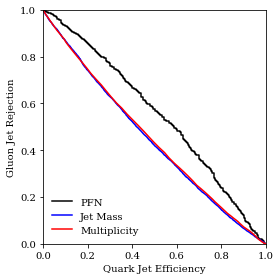

In [38]:
#Bins 1 and 2
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 20000, 15914, 3000
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 10
batch_size = 500

################################################################################

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('PFN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()

Create datasets out of mass bins 2 and 3 to feed into PFN (Particle Flow Network) machine learning model

In [39]:
#Bins 2 and 3
X = np.concatenate([jet_array_2, jet_array_3])[:,:,:4]
y = np.concatenate([np.ones(len(jet_array_2)), np.zeros(len(jet_array_3))])
#del jet_array_2, jet_array_3

In [40]:
X.shape

(65210, 160, 4)

Run PFN model on mass bins 2 and 3 to see how well model can distinguish between jets in those bins.

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_8 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_8[0][0]               


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


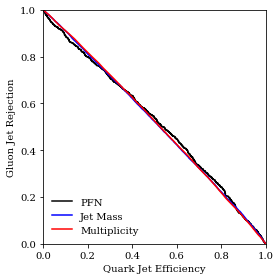

In [41]:
#Bins 2 and 3
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 20000, 42210, 3000
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 10
batch_size = 500

################################################################################

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('PFN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()

Create datasets out of mass bins 3 and 4 to feed into PFN (Particle Flow Network) machine learning model

In [42]:
#Bins 3 and 4
X = np.concatenate([jet_array_3, jet_array_4])[:,:,:4]
y = np.concatenate([np.ones(len(jet_array_3)), np.zeros(len(jet_array_4))])
#del jet_array_3, jet_array_4

In [43]:
X.shape

(50122, 160, 4)

Run PFN model on mass bins 3 and 4 to see how well model can distinguish between jets in those bins.

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_15 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_15[0][0]              


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


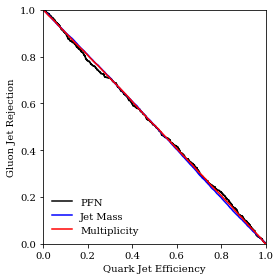

In [44]:
#Bins 3 and 4
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 20000, 27122, 3000
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 10
batch_size = 500

################################################################################

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('PFN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()

In [45]:
#Bins 4 and 5
X = np.concatenate([jet_array_4, jet_array_5])[:,:,:4]
y = np.concatenate([np.ones(len(jet_array_4)), np.zeros(len(jet_array_5))])
#del jet_array_3, jet_array_4

In [46]:
X.shape

(34060, 160, 4)

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_22 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_22[0][0]              


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


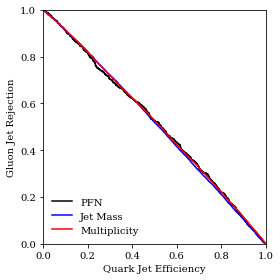

In [47]:
#Bins 4 and 5
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 20000, 11060, 3000
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 10
batch_size = 500

################################################################################

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('PFN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()

In [48]:
#Bins 5 and 6
X = np.concatenate([jet_array_5, jet_array_6])[:,:,:4]
y = np.concatenate([np.ones(len(jet_array_5)), np.zeros(len(jet_array_6))])
#del jet_array_3, jet_array_4

In [49]:
X.shape

(27180, 160, 4)

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_29 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_29[0][0]              


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


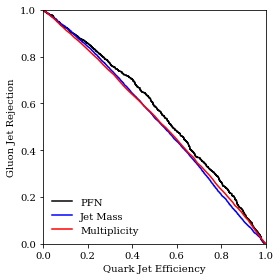

In [50]:
#Bins 5 and 6
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 20000, 4180, 3000
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 10
batch_size = 500

################################################################################

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('PFN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()

AUC plot

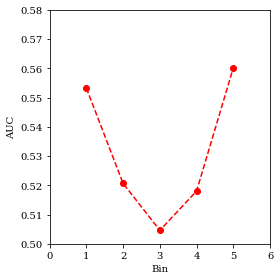

In [51]:
plt.plot([1, 2, 3, 4, 5], [0.5532831179580651, 0.5206707364879795, 0.5045980551536546, 0.5180404659050826, 0.5602227513238003], "r--o")
plt.axis([0, 6, 0.5, 0.58])
plt.xlabel('Bin')
plt.ylabel('AUC')
plt.show()

**Signal Injection**

Pull events with 2 gluons

In [52]:
indexes_gluon_events = []

index = 0
for event in event_jet_labels_2:
    if event[0] == 21 and event[1] == 21:
        indexes_gluon_events.append(index)
    index += 1

event_list_2_gluons = [event_list_2[j] for j in indexes_gluon_events]
sum_mass_events_2_gluons = [sum_mass_events_2[j] for j in indexes_gluon_events]

In [54]:
print(len(event_list_2_gluons))
print(len(sum_mass_events_2_gluons))

8650
8650


Sort into mass bins

In [56]:
index_bin_1_gluon = []
index_bin_2_gluon = []
index_bin_3_gluon = []
index_bin_4_gluon = [] 
index_bin_5_gluon = []
index_bin_6_gluon = []

i = 0
for event_mass in sum_mass_events_2_gluons:
    if event_mass > 64.67 and event_mass <= 700:
        index_bin_1_gluon.append(i)
    elif event_mass > 700 and event_mass <= 800:
        index_bin_2_gluon.append(i)
    elif event_mass > 800 and event_mass <= 900:
        index_bin_3_gluon.append(i)
    elif event_mass > 900 and event_mass <= 1000:
        index_bin_4_gluon.append(i)
    elif event_mass > 1000 and event_mass <= 1264.67:
        index_bin_5_gluon.append(i)
    elif event_mass > 1264.67 and event_mass <= 2624.1:
        index_bin_6_gluon.append(i)
        
    i += 1

In [57]:
print(len(index_bin_1_gluon))
print(len(index_bin_2_gluon))
print(len(index_bin_3_gluon))
print(len(index_bin_4_gluon))
print(len(index_bin_5_gluon))
print(len(index_bin_6_gluon))

865
2683
2784
1091
966
261


Grab all events from mass bin 3, insert into mass bins we already have

In [104]:
events_bin3_gluons = [event_list_2_gluons[j] for j in index_bin_3_gluon]

In [105]:
len(events_bin3_gluons)

2784

In [2]:
len(events_bin3_gluons)

NameError: name 'events_bin3_gluons' is not defined

In [106]:
events_bin3_gluons_array = np.array(events_bin3_gluons)

In [107]:
events_bin3_gluons_array.shape

(2784, 2)

In [108]:
jet_bin3_gluons = []
for event in events_bin3_gluons:
    for jet in event:
        jet_bin3_gluons.append(jet)

In [109]:
len(jet_bin3_gluons)

5568

In [110]:
for jet in jet_bin3_gluons:
    jet_mass_bin3.append(jet)

In [111]:
len(jet_mass_bin3)

39648

In [112]:
jet_mass_bin3 = list(jet_mass_bin3)

In [113]:
jet_array_3 = np.zeros((len(jet_mass_bin3),160,6))
for i in range(len(jet_mass_bin3)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_3[i,j,k] = jet_mass_bin3[i][j][k]
            except IndexError:
                jet_array_3[i,j,k] = 0
print("Mass bin 3 done")

Mass bin 3 done


Run PFN model

In [127]:
#Bins 2 and 3
X = np.concatenate([jet_array_2, jet_array_3])[:,:,:4]
y = np.concatenate([np.ones(len(jet_array_2)), np.zeros(len(jet_array_3))])

In [128]:
X.shape

(70778, 160, 4)

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_71 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_71[0][0]              

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


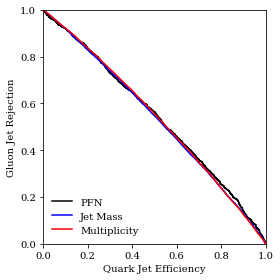

In [129]:
#Bins 2 and 3
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 20000, 47778, 3000
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 10
batch_size = 500

################################################################################

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('PFN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()

In [130]:
#Bins 3 and 4
X = np.concatenate([jet_array_3, jet_array_4])[:,:,:4]
y = np.concatenate([np.ones(len(jet_array_3)), np.zeros(len(jet_array_4))])

In [131]:
X.shape

(55690, 160, 4)

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_78 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_78[0][0]              

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


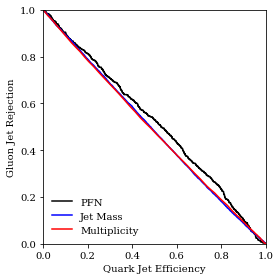

In [132]:
#Bins 3 and 4
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 20000, 32690, 3000
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 10
batch_size = 500

################################################################################

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('PFN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()

Bins 2-3: w/o signal: 0.5206707364879795, w/ signal added once: 0.542236688931837

Bins 3-4: w/o signal: 0.5045980551536546, w/ signal added once: 0.5146024911628694

Try adding signal twice

In [133]:
for jet in jet_bin3_gluons:
    jet_mass_bin3.append(jet)

In [134]:
len(jet_mass_bin3)

45216

In [135]:
jet_mass_bin3 = list(jet_mass_bin3)

In [136]:
jet_array_3 = np.zeros((len(jet_mass_bin3),160,6))
for i in range(len(jet_mass_bin3)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_3[i,j,k] = jet_mass_bin3[i][j][k]
            except IndexError:
                jet_array_3[i,j,k] = 0
print("Mass bin 3 done")

Mass bin 3 done


In [137]:
#Bins 2 and 3
X = np.concatenate([jet_array_2, jet_array_3])[:,:,:4]
y = np.concatenate([np.ones(len(jet_array_2)), np.zeros(len(jet_array_3))])

In [138]:
X.shape

(76346, 160, 4)

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_85 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_85[0][0]              

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


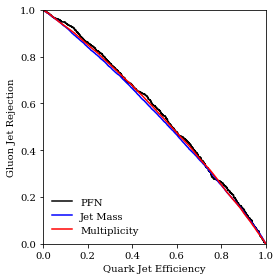

In [139]:
#Bins 2 and 3
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 20000, 53346, 3000
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 10
batch_size = 500

################################################################################

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('PFN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()

In [140]:
#Bins 3 and 4
X = np.concatenate([jet_array_3, jet_array_4])[:,:,:4]
y = np.concatenate([np.ones(len(jet_array_3)), np.zeros(len(jet_array_4))])

In [141]:
X.shape

(61258, 160, 4)

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_92 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_92[0][0]              

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


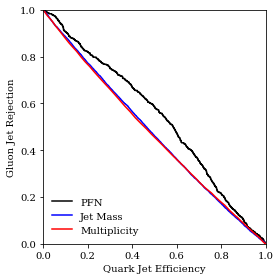

In [142]:
#Bins 3 and 4
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 20000, 38258, 3000
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 10
batch_size = 500

################################################################################

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('PFN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()

Bins 2-3: w/o signal: 0.5206707364879795, w/ signal added twice: 0.5616150265480542

Bins 3-4: w/o signal: 0.5045980551536546, w/ signal added twice: 0.5395342067292096

Try adding signal 4 times

In [143]:
for jet in jet_bin3_gluons:
    jet_mass_bin3.append(jet)
    
for jet in jet_bin3_gluons:
    jet_mass_bin3.append(jet)

In [144]:
len(jet_mass_bin3)

56352

In [145]:
jet_mass_bin3 = list(jet_mass_bin3)

In [146]:
jet_array_3 = np.zeros((len(jet_mass_bin3),160,6))
for i in range(len(jet_mass_bin3)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_3[i,j,k] = jet_mass_bin3[i][j][k]
            except IndexError:
                jet_array_3[i,j,k] = 0
print("Mass bin 3 done")

Mass bin 3 done


In [147]:
#Bins 2 and 3
X = np.concatenate([jet_array_2, jet_array_3])[:,:,:4]
y = np.concatenate([np.ones(len(jet_array_2)), np.zeros(len(jet_array_3))])

In [148]:
X.shape

(87482, 160, 4)

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:
Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_99 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_99[0][0]              

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


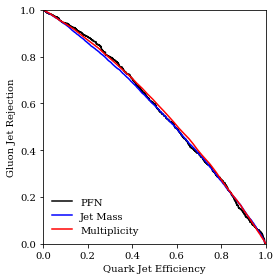

In [149]:
#Bins 2 and 3
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 20000, 64482, 3000
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 10
batch_size = 500

################################################################################

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('PFN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()

In [150]:
#Bins 3 and 4
X = np.concatenate([jet_array_3, jet_array_4])[:,:,:4]
y = np.concatenate([np.ones(len(jet_array_3)), np.zeros(len(jet_array_4))])

In [151]:
X.shape

(72394, 160, 4)

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_106 (Activation)     (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_106[0][0]             

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


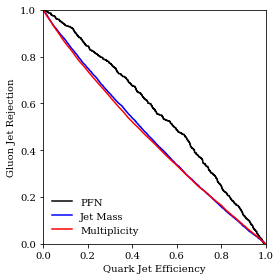

In [152]:
#Bins 3 and 4
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 20000, 49394, 3000
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 10
batch_size = 500

################################################################################

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('PFN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()

Bins 2-3: w/o signal: 0.5206707364879795, w/ signal added 4 times: 0.572027105093788

Bins 3-4: w/o signal: 0.5045980551536546, w/ signal added 4 times: 0.5553809216418196

Try adding signal 16 times for good measure

In [153]:
for i in range(12):  
    for jet in jet_bin3_gluons:
        jet_mass_bin3.append(jet)

In [154]:
len(jet_mass_bin3)

123168

In [155]:
jet_mass_bin3 = list(jet_mass_bin3)

In [156]:
jet_array_3 = np.zeros((len(jet_mass_bin3),160,6))
for i in range(len(jet_mass_bin3)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_3[i,j,k] = jet_mass_bin3[i][j][k]
            except IndexError:
                jet_array_3[i,j,k] = 0
print("Mass bin 3 done")

Mass bin 3 done


In [157]:
#Bins 2 and 3
X = np.concatenate([jet_array_2, jet_array_3])[:,:,:4]
y = np.concatenate([np.ones(len(jet_array_2)), np.zeros(len(jet_array_3))])

In [158]:
X.shape

(154298, 160, 4)

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:
Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_113 (Activation)     (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_113[0][0]             

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


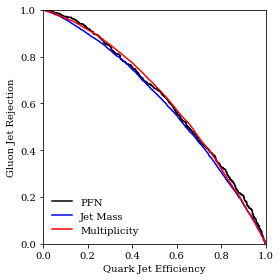

In [159]:
#Bins 2 and 3
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 20000, 131298, 3000
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 10
batch_size = 500

################################################################################

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('PFN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()

In [160]:
#Bins 3 and 4
X = np.concatenate([jet_array_3, jet_array_4])[:,:,:4]
y = np.concatenate([np.ones(len(jet_array_3)), np.zeros(len(jet_array_4))])

In [161]:
X.shape

(139210, 160, 4)

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:
Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_120 (Activation)     (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_120[0][0]             

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


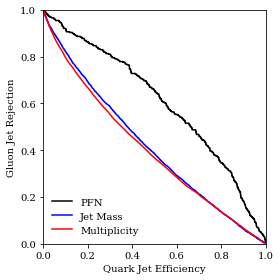

In [163]:
#Bins 3 and 4
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 20000, 116210, 3000
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 10
batch_size = 500

################################################################################

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('PFN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()

Bins 2-3: w/o signal: 0.5206707364879795, w/ signal added 16 times: 0.6217232871512621

Bins 3-4: w/o signal: 0.5045980551536546, w/ signal added 16 times: 0.6057613996710156

Therefore, as we have a larger signal injection, we see a larger effect on AUC. These effects are apparent even when we add 5568 jets, although they only change the AUC by 0.01-0.02. Let's see how small of an effect this method can detect.

In [1]:
for i in range(0, 2000):
    jet_mass_bin3.append(jet_bin3_gluons[i])

NameError: name 'jet_mass_bin3' is not defined

In [ ]:
len(jet_mass_bin3)